# 02-pinkify-dir-dev.ipynb

## Import packages

In [1]:
from pathlib import Path
import sys
# Third-party imports
import imageio as iio
import matplotlib.pyplot as plt
import napari
import numpy as np
from skimage import color, exposure, transform, util
# Custom module imports
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)
from src import helpers

In [2]:
%load_ext autoreload
%autoreload 2

## Setup NB and load pink image

In [3]:
viewer = napari.Viewer()

In [4]:
project_dir = Path.cwd().parent.resolve()
project_dir

WindowsPath('C:/Users/cgusb/projects/archipelago')

## Load image

In [5]:
def load_img(img_dir, img_n=0, resize_nrows=None, img_suffix='.jpg'):
    img_paths = [path for path in Path(img_dir).glob(f'*{img_suffix}')]
    img_paths.sort()
    img = iio.imread(img_paths[img_n])
    if resize_nrows is not None:
        img = helpers.resize_by_nrows(img, resize_nrows)
    return img

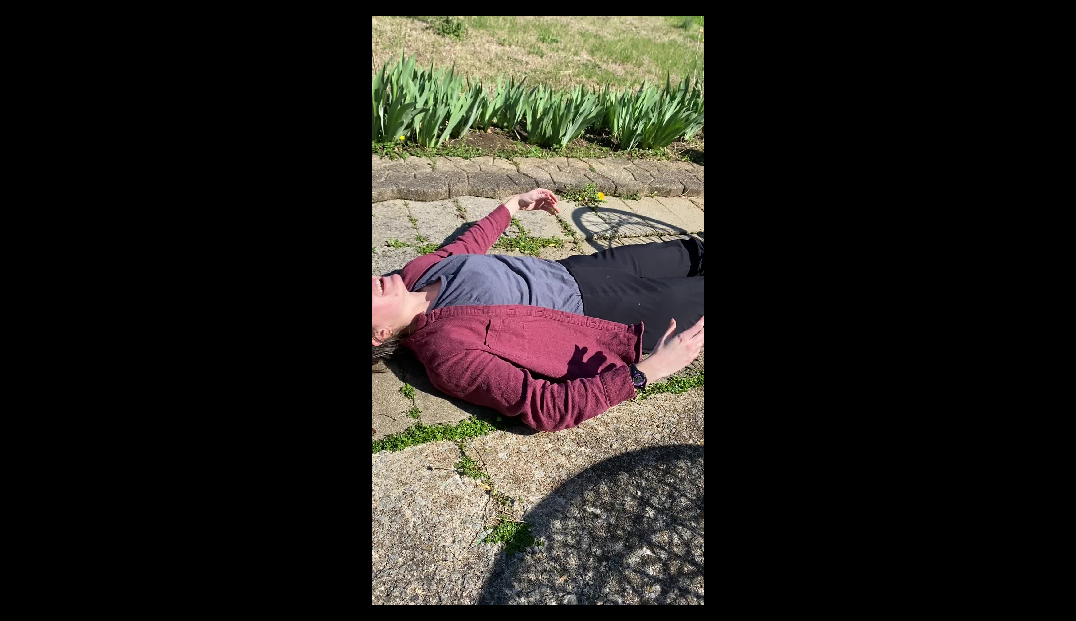

In [6]:
vid_frames_dir = Path(project_dir / 'videos/mc-laying/frames/')
img = load_img(vid_frames_dir, img_n=0)
helpers.view(viewer, img)

## Pinkify image

pink_hsv[:, :, 1].min()=0.08333333333333337
pink_hsv[:, :, 1].max()=0.08333333333333337


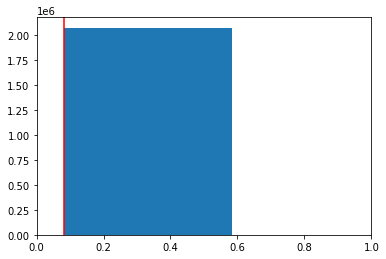

In [7]:
pink_hsv = helpers.pink_like(img, img_type='hsv')
print(f'{pink_hsv[:, :, 1].min()=}')
print(f'{pink_hsv[:, :, 1].max()=}')
pink_s_mean = pink_hsv[:, :, 1].mean()
fig, ax = helpers.plot_hist(pink_hsv, chan=1, cumul=True, vlines=pink_s_mean)
plt.show()

In [8]:
def pinkify(img, convert_rgb=False):
    pink_rgb = helpers.pink_like(img)
    pink_hsv = color.rgb2hsv(pink_rgb)
    img_hsv = color.rgb2hsv(img)
    pink_hsv[:, :, 1] = img_hsv[:, :, 1]
    if convert_rgb:
        pink_rgb = color.hsv2rgb(pink_hsv)
        return util.img_as_ubyte(pink_rgb)
    return pink_hsv

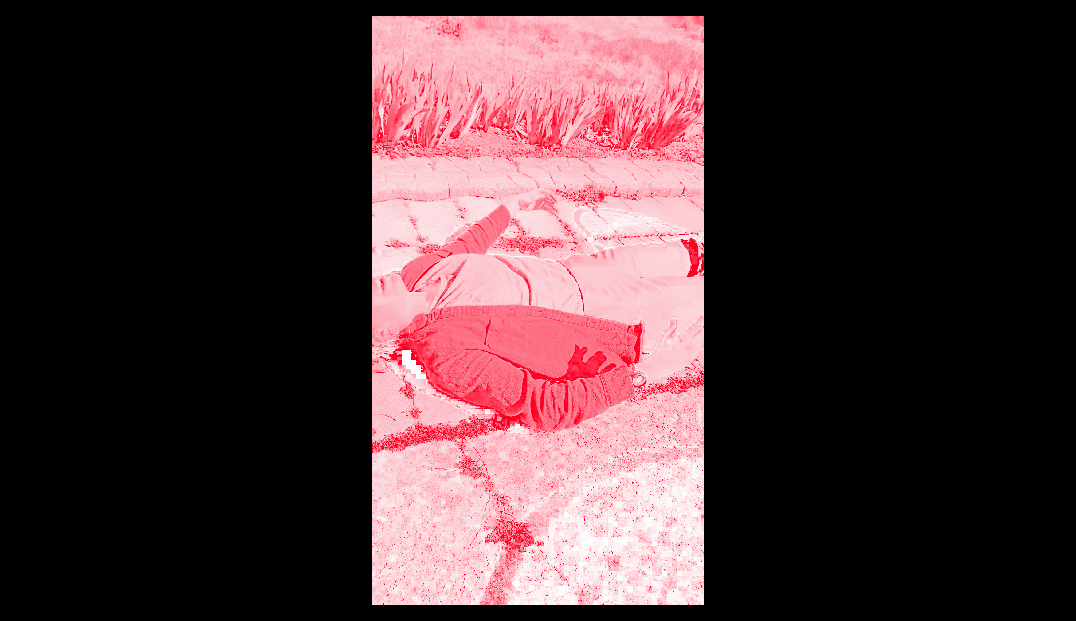

In [9]:
pink_img_hsv = pinkify(img)
pink_img_rgb = color.hsv2rgb(pink_img_hsv)
helpers.view(viewer, pink_img_rgb)

## Rescale intensity of saturation

Rather than span [0, 1], saturation intensity will be rescaled to a range within some value of the saturation of the all pink image

pink_s_mean=0.08333333333333323


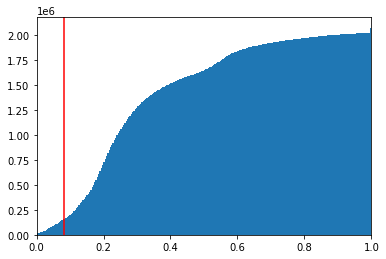

In [10]:
fig, ax = helpers.plot_hist(pink_img_hsv, chan=1, cumul=True, vlines=pink_s_mean)
print(f'{pink_s_mean=}')
plt.show()

In [11]:
def rescale_by_val(img, center_val, span):
    img = exposure.rescale_intensity(
        img, out_range=(center_val - span / 2, center_val + span / 2)
    )
    return img

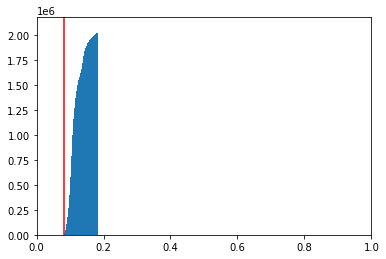

In [12]:
pink_img_rescaled_hsv = pink_img_hsv.copy()
pink_img_rescaled_hsv[:, :, 1] = exposure.rescale_intensity(
    pink_img_hsv[:, :, 1], out_range=(pink_s_mean, pink_s_mean + 0.1)
)
fig, ax = helpers.plot_hist(
    pink_img_rescaled_hsv, chan=1, cumul=True, vlines=pink_s_mean
)
plt.show()

## Add pinkified image to pink canvas

In [13]:
def img_to_canvas(
    hsv_img, canvas_size=(1080, 1920, 3), col_offset='center', out_type='rgb'
):
    # Make pink canvas
    canvas = helpers.pink(canvas_size)
    canvas_hsv = color.rgb2hsv(canvas)
    # Rescale image to fit on canvas
    canvas_rows, canvas_cols, canvas_chan = canvas_size
    hsv_img = helpers.resize_by_nrows(hsv_img, canvas_rows)
    img_rows, img_cols, img_chan = hsv_img.shape
    # Add pink image to part of pink canvas
    if col_offset == 'center':
        col_offset = canvas_cols // 2 - (img_cols // 2) 
    else:
        col_offset = 0
    canvas_hsv[:, col_offset:col_offset + img_cols, :] = hsv_img
    if out_type.lower() == 'rgb':
        canvas_rgb = color.hsv2rgb(canvas_hsv)
        canvas_rgb = util.img_as_ubyte(canvas_rgb)
        return canvas_rgb
    return canvas_hsv

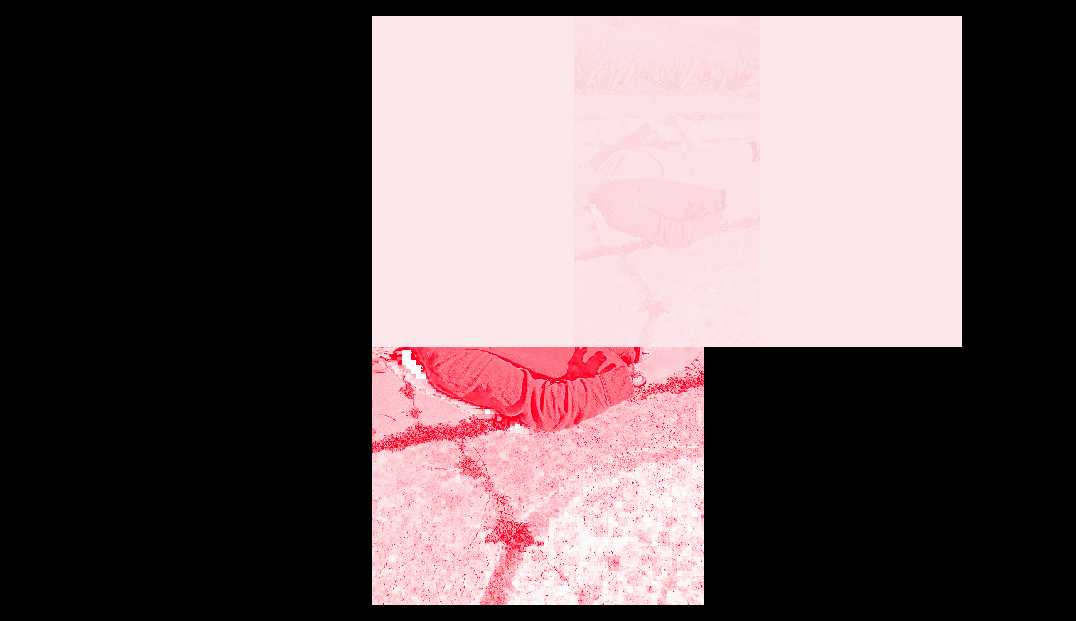

In [18]:
pink_img_canvas = img_to_canvas(pink_img_rescaled_hsv, out_type='rgb')
helpers.view(viewer, pink_img_canvas)

## Pinkify all images in directory

In [21]:
def pinkify_dir(
    img_dir, save_dir, col_offset='center', canvas_size=(1080, 1920, 3), 
    img_suffix='.jpg'
):
    img_paths = [path for path in img_dir.glob(f'*{img_suffix}')]
    img_paths.sort()
    nimgs = len(img_paths)
    # Check save_dir and make directory or return error if exists
    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=False)
    for i, img_path in enumerate(img_paths):
        print(f'Pinkifying image {i + 1}/{nimgs}...')
        # Load image
        # img = load_img(img_dir, img_n=0)
        img = iio.imread(img_path)
        # Pinkify image
        pink_img_hsv = pinkify(img, convert_rgb=False)
        # Rescale saturation to +/- sat spread around mean
        pink_s_mean = pink_hsv[:, :, 1].mean()
        pink_img_rescaled_hsv = pink_img_hsv.copy()
        pink_img_rescaled_hsv[:, :, 1] = exposure.rescale_intensity(
            pink_img_hsv[:, :, 1], out_range=(pink_s_mean, pink_s_mean + 0.1)
        )
        # Add pink image to pink canvas
        pink_img_canvas = img_to_canvas(pink_img_rescaled_hsv, col_offset='center')
        # Save image
        save_path = Path(save_dir / f'{str(i).zfill(3)}.jpg')
        iio.imsave(save_path, pink_img_canvas)
    print(f'{nimgs} images saved: {save_dir}')

In [22]:
vid_frames_dir = Path(project_dir / 'videos/mc-laying/frames/')
save_dir = Path(project_dir / 'videos/mc-laying/pinkified/')
pink_imgs = pinkify_dir(vid_frames_dir, save_dir)

Pinkifying image 1/226...
Pinkifying image 2/226...
Pinkifying image 3/226...
Pinkifying image 4/226...
Pinkifying image 5/226...
Pinkifying image 6/226...
Pinkifying image 7/226...
Pinkifying image 8/226...
Pinkifying image 9/226...
Pinkifying image 10/226...
Pinkifying image 11/226...
Pinkifying image 12/226...
Pinkifying image 13/226...
Pinkifying image 14/226...
Pinkifying image 15/226...
Pinkifying image 16/226...
Pinkifying image 17/226...
Pinkifying image 18/226...
Pinkifying image 19/226...
Pinkifying image 20/226...
Pinkifying image 21/226...
Pinkifying image 22/226...
Pinkifying image 23/226...
Pinkifying image 24/226...
Pinkifying image 25/226...
Pinkifying image 26/226...
Pinkifying image 27/226...
Pinkifying image 28/226...
Pinkifying image 29/226...
Pinkifying image 30/226...
Pinkifying image 31/226...
Pinkifying image 32/226...
Pinkifying image 33/226...
Pinkifying image 34/226...
Pinkifying image 35/226...
Pinkifying image 36/226...
Pinkifying image 37/226...
Pinkifying